In [ ]:
!pip install dill nltk matplotlib seaborn scikit-learn spacy

In [ ]:
!pip install tensorflow_hub tensorflow

In [ ]:
!pip install numpy

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import dill
import glob, csv
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt') # Download this as this allows you to tokenize words in a string.
lemmatizer = WordNetLemmatizer()


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import re
import string
import seaborn as sns
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/catking14/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/catking14/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Convert CSV to Dataframe

In [ ]:
#convert csv to dataframe
train_dataframe = pd.read_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/mega_train.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_dataframe = pd.read_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/mega_test.csv")

In [ ]:
new_csv = []
skip = True

with open("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train.csv", "r") as attack_csv:
  content = csv.reader(attack_csv)

  for row in content:
    if skip == True:
      skip = False
      continue

    # print(row[0])
    str_temp = re.findall(r"'(.*?)'|\"(.*?)\"", row[0])
    final_str = []

    for words in str_temp:
      if(words[0] == ""):
        final_str.append(words[1])
      else:
        final_str.append(words[0])
    new_csv.append([" ".join(final_str), row[1]])
    # break

with open("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train_str.csv", "w") as attack_str:
  writer = csv.writer(attack_str)
  writer.writerow(["text", "Author_num"])

  for article in new_csv:
    writer.writerow(article)

In [ ]:
train_dataframe.head()

,index,text,Author
0,3225,Treasury Secretary Robert Rubin goes to Capito...,AaronPressman
1,744,U.S. banks will be able to significantly incre...,AaronPressman
2,737,Supreme Court justices Wednesday sharply quest...,AaronPressman
3,740,"Fast running out of options, federal credit un...",AaronPressman
4,3241,The U.S. Commerce Department showed an unexpec...,AaronPressman


In [ ]:
test_dataframe.head()

,index,text,Author,hopeful_test
0,8,Britain's Ladbroke Group Plc Monday concluded ...,SimonCowell,1
1,10,Scottish Amicable on Thursday asked for firm o...,SimonCowell,1
2,15,Scottish Amicable's plans to float on the stoc...,SimonCowell,1
3,17,The head of the Securities and Investments Boa...,SimonCowell,1
4,20,Britain's Britannic Assurance declared on Tues...,SimonCowell,1


 Create new column with author number mappings for ML

In [ ]:
# create new col with author number mappings for ML
auth_sort = sorted(train_dataframe['Author'].unique())
dictOfAuthors = { i : auth_sort[i] for i in range(0, len(auth_sort) ) }
swap_dict = {value:key for key, value in dictOfAuthors.items()}
train_dataframe['Author_num'] = train_dataframe['Author'].map(swap_dict)

In [ ]:
# create new col with author number mappings for ML
auth_sort = sorted(test_dataframe['Author'].unique())
dictOfAuthors = { i : auth_sort[i] for i in range(0, len(auth_sort) ) }
swap_dict = {value:key for key, value in dictOfAuthors.items()}
test_dataframe['Author_num'] = test_dataframe['Author'].map(swap_dict)

In [ ]:
train_dataframe.head()

,index,text,Author,Author_num
0,3225,Treasury Secretary Robert Rubin goes to Capito...,AaronPressman,0
1,744,U.S. banks will be able to significantly incre...,AaronPressman,0
2,737,Supreme Court justices Wednesday sharply quest...,AaronPressman,0
3,740,"Fast running out of options, federal credit un...",AaronPressman,0
4,3241,The U.S. Commerce Department showed an unexpec...,AaronPressman,0


In [ ]:
test_dataframe.head()

,index,text,Author,hopeful_test,Author_num
0,8,Britain's Ladbroke Group Plc Monday concluded ...,SimonCowell,1,44
1,10,Scottish Amicable on Thursday asked for firm o...,SimonCowell,1,44
2,15,Scottish Amicable's plans to float on the stoc...,SimonCowell,1,44
3,17,The head of the Securities and Investments Boa...,SimonCowell,1,44
4,20,Britain's Britannic Assurance declared on Tues...,SimonCowell,1,44


In [ ]:
# only left text(article) in dataframe
test_dataframe = test_dataframe.drop(columns='Author')
# train_dataframe = train_dataframe.drop(columns='Author')
# train_dataframe = train_dataframe.drop(columns='index')
test_dataframe = test_dataframe.drop(columns='index')
test_dataframe = test_dataframe.drop(columns='hopeful_test')

In [ ]:
# check out excerpted data
test_dataframe.head()

,text,Author_num
0,Britain's Ladbroke Group Plc Monday concluded ...,44
1,Scottish Amicable on Thursday asked for firm o...,44
2,Scottish Amicable's plans to float on the stoc...,44
3,The head of the Securities and Investments Boa...,44
4,Britain's Britannic Assurance declared on Tues...,44


In [ ]:
train_dataframe.head()

,text,Author_num
0,Treasury Secretary Robert Rubin goes to Capito...,0
1,U.S. banks will be able to significantly incre...,0
2,Supreme Court justices Wednesday sharply quest...,0
3,"Fast running out of options, federal credit un...",0
4,The U.S. Commerce Department showed an unexpec...,0


In [ ]:
list_to_choose_train = train_dataframe.text.apply(lambda x : len(x)) > 0
train_df_article = train_dataframe[list_to_choose_train]

In [ ]:
list_to_choose_test = test_dataframe.text.apply(lambda x : len(x)) > 0
test_df_article = test_dataframe[list_to_choose_test]

In [ ]:
train_df_article.to_csv(r'/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/train.csv', index = False)

In [ ]:
test_df_article.to_csv(r'/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/test_v3.csv', index = False)

To use *torchtext* here, we might need to re-install old version of it.

Here we use torchtext 0.6.0.

In [4]:
# We have to use old version of torchtext to use data.Field attribute
!pip install torchtext==0.6.0

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!python -m spacy download en_core_web_sm

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.6 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
#import torch
#import spacy
#nlp = spacy.load("en_core_web_sm")
from torchtext import data
TEXT = data.Field(sequential=True, tokenize="spacy", tokenizer_language="en_core_web_sm", lower=True, include_lengths=True) # new tokenizer_language to fit new model
SCORE = data.Field(sequential=False, use_vocab=False)

2023-12-25 14:44:40.075760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 14:44:40.075883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 14:44:40.167188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 14:44:40.246521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Utilizing Datafields

In [3]:
datafields = [("text", TEXT),
              ("Author_num", SCORE)]

train= data.TabularDataset(
    path='./data/train.csv',
    format='csv',fields=datafields,skip_header = True)

val = data.TabularDataset(
    path='./data/test.csv',
    format='csv',fields=datafields,skip_header = True)


# take only partial example
# train_examples = [example for example in train]
# train_subset = train_examples[:1]
# train = data.Dataset(train_subset, fields=datafields)

In [ ]:
ex1 = [['who', 'is', 'threr'], 1]
ex2 = data.Example.fromlist(ex1, fields=datafields)
print(ex2.text)
print(ex2.Author_num)
print(train[0].text)

In [4]:
from torchtext import vocab
from torchtext.vocab import GloVe
TEXT.build_vocab(train, val, min_freq = 3, vectors=GloVe(name='6B', dim=100))

**Iterators**

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device according to hardware support
BATCH_SIZE = 64
# train_iterator = data.BucketIterator(
#     train,
#     batch_size = BATCH_SIZE,
#     sort_key = lambda x: len(x.text),
#     sort_within_batch = True,
#     repeat=False,
#     shuffle=True,
#     device = device)

val_iterator = data.BucketIterator(
    val,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)


# print(train.examples[0].text)
# print(val_iterator.data()[0].text)

# for batch in val_iterator:
#   c, cl = batch.text
#   print(c[0])
#   break


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib
import pandas as pd
import dill
import random
import torch.optim as optim
import matplotlib.pyplot as plt

**Network Architecture**

In [7]:
class AuthorClassifier(nn.Module):

    def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
      super(AuthorClassifier, self).__init__()

      if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
        raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

      self.mode = mode
      self.output_size = output_size
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.embedding_length = embedding_length
      self.embedding = nn.Embedding(self.vocab_size,self.embedding_length)
      self.embedding.weight = nn.Parameter(word_embeddings,requires_grad = True)  # True to keep gradient



      if self.mode == 'rnn':
        self.network = nn.RNN(self.embedding_length,self.hidden_size)
      elif self.mode == 'lstm':
        self.network = nn.LSTM(self.embedding_length,self.hidden_size)
      elif self.mode == 'gru':
        self.network = nn.GRU(self.embedding_length,self.hidden_size)
      elif self.mode == 'bilstm':
        self.network = nn.LSTM(self.embedding_length,self.hidden_size,bidirectional = True)


      self.fclayer = nn.Linear(self.hidden_size,self.output_size)


    def forward(self, text, text_lengths):
      text_embeddings = self.embedding(text)
      pack_sequence = nn.utils.rnn.pack_padded_sequence(text_embeddings,text_lengths.cpu()) # lengths.cpu() for matching new input format

      if self.mode in ('lstm','bilstm'):
        a,(hidden,cell) = self.network(pack_sequence)
        if self.mode == 'bilstm':
          hidden = hidden[0,:,:]+ hidden[1,:,:]
      else:
        a,hidden = self.network(pack_sequence)
      hidden = hidden.squeeze(0)
      pred = self.fclayer(hidden)
      return pred

**Training and testing models**

In [8]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay  # new version of plot_confusion_matrix

# grad_cache = []
def store_grad(grad):
  grad_cache.append(grad)
  return grad

def train_classifier(model, dataset_iterator, loss_function, optimizer, num_epochs, log = "runs", verbose = False, recurrent = True):
  writer = SummaryWriter(log_dir=log)
  model.train()
  step = 0
  f1score_train = []
  accuracy_train = []
  loss_train = []

#   model.embedding.weight.register_hook(store_grad)
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    total_loss = 0
    f1 = 0
    f1_step = 0

    for batch in dataset_iterator:
      comment, comment_lengths = batch.text
      labels = batch.Author_num

      # print(comment.size())
      # print(labels)

      batch_size = len(labels)
      optimizer.zero_grad()
      output = model(comment, comment_lengths).squeeze(0)
      # model.embedding.weight.retain_grad()

      # vocab_list = TEXT.vocab.itos
      # tmp = []
      # for idx in range(64):
      #   tmp.append(vocab_list[comment[0][idx]])

      # print(tmp)

      # reshape when only one article in training set
      if output.size() == torch.Size([50]):
        output = output.view(1, 50)

      loss = loss_function(output, labels.long())
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),0.5)
      optimizer.step()

      pred = torch.max(output.data,1).indices
      f1 += sklearn.metrics.f1_score((labels.cpu()).numpy(), (pred.cpu()).numpy(),average= 'macro')
      correct += (torch.sum(pred == labels)).item()
      total += len(labels)
      total_loss += loss.item()
      f1_step += 1

      if ((step % 100) == 0):
        writer.add_scalar("Loss/train", total_loss/total, step)
        writer.add_scalar("Acc/train", correct/total, step)
        writer.add_scalar("F1 Score/train", f1/f1_step, step)

      step = step+1
    f1score_train.append(f1/f1_step)
    loss_train.append(total_loss/total)
    accuracy_train.append(correct/total)
    print('---Training statistics---',"Epoch: %s Acc: %s Loss: %s"%(epoch+1, correct/total, total_loss/total),'F1 Score:',f1/f1_step,)

  return loss_train,f1score_train,accuracy_train

def evaluate_classifier(model, dataset_iterator, loss_function, recurrent = True):
  model.eval()

  correct = 0
  total = 0
  total_loss = 0
  overall_pred = []
  overall_label = []
  accuracy_test = []
  loss_test = []
  f1_step = 0
  f1 = 0

  for batch in dataset_iterator:
    comment, comment_lengths = batch.text
    labels = batch.Author_num   # tag of author number
    output = model(comment, comment_lengths).squeeze(0)
    # print(output.data)
    # print(len(output.data))
    # prediction will be the values in each row
    # they represent the possibility(weight) of an article which belongs to jth author(in jth row)

    # print(comment[0], comment_lengths)
    # print(model.embedding(comment[0]))
    # print(dataset_iterator.data())
    # print(len(labels))

    # print(len(model.embedding.weight.grad))
    # model.embedding.weight.grad stores the gradient of each word to it's embedding
    # use TEXT.vocab.stoi to generate dictionary to map token: idx, then use idx to get grad by model.embedding.weight.grad[idx]

    # vocab_list = TEXT.vocab.itos
    # tmp = []
    # for idx in range(64):
    #   tmp.append(vocab_list[comment[0][idx]])

    # print(tmp)

    loss = loss_function(output, labels.long()) # .long means .to(torch.int64)
    pred = torch.max(output.data,1).indices
    correct += (torch.sum(pred == labels)).item()
    total += len(labels)
    total_loss += loss.item()
    ap = pred.cpu()
    a = np.asarray(ap)
    labels = labels.cpu()
    b = np.asarray(labels)
    f1_step += 1
    overall_pred.append(a)
    overall_label.append(b)

  overall_p= [val for sublist in overall_pred for val in sublist]
  overall_l = [val for sublist in overall_label for val in sublist]
  f1ss = sklearn.metrics.f1_score(overall_l,overall_p,average= 'macro')
  accuracy_test.append(correct/total)
  loss_test.append(total_loss/total)
  print("Validation statistics: Acc: %s Loss: %s"%(correct/total, total_loss/total),'F1 Score:',f1ss)
  return overall_pred,overall_label,accuracy_test,f1ss,loss_test

Simularity calculation


In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

In [10]:
similarity_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def similarity_cal(sentence1, sentence2):
  # create sentence embedding
  embedding1 = similarity_model([sentence1])[0]
  embedding2 = similarity_model([sentence2])[0]

  # calculate cosine simularity
  cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
  # print("相似度:", cosine_similarity)

  return cosine_similarity

2023-12-25 14:46:41.657649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31150 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [ ]:
ok = [2, 3, 1]
print(sorted(ok))
print(ok)

[1, 2, 3]
[2, 3, 1]


#### Import words list from pregenerated TF-IDF word list

In [11]:
words_can_replace = []

with open("./data/tfidf-words-20.csv", "r") as words_list:
    reader = csv.reader(words_list)
    
    for row in reader:
        words_can_replace.append(row[0])
        
print(words_can_replace[0])
print(type(words_can_replace[0]))

farc
<class 'str'>


Crucial word search and replacement generator

In [12]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [15]:
def create_replacement(article_model, embedding_grad, example, influence_rank=5, replacement_rank=10, sim_threshold=0.9):
    # calculate gradient norm for each word's embedding
    grad_norm = torch.norm(embedding_grad, dim=1)
    grad_dict = {}

    for i in range(len(grad_norm)):
        grad_dict[vocab_list[i]] = grad_norm[i]

    grad_dict_sorted = {k: v for k, v in sorted(grad_dict.items(), key=lambda item: item[1], reverse=True)}
    grad_list_sorted = list(grad_dict_sorted.keys())
    to_replace = []

    for choose in grad_list_sorted:
        if influence_rank == 0:
            to_replace = grad_list_sorted
            break

        if choose in example.text:
            to_replace.append(choose)

        if len(to_replace) == influence_rank:
            break

    
    """
    The part below is aimed to find top k closest words of a certain word.
    We use euclidean distance in word embedding to calculate.
    """
    words_in_article = []
    for info in example.text:   # example.text is the input article
        words_in_article.append(vocab_dict[info])
    
    for info in words_can_replace:   # put words from tf-idf in 
        words_in_article.append(vocab_dict[info])

    words_in_article = torch.tensor(words_in_article, dtype=torch.int64)
    words_in_article = words_in_article.to(device)  # move to same device as model
    output = article_model.embedding(words_in_article)  # get embeddings of words
    np_word_dict = {}

    # create dictionary of word-embedding pair of np.array of embeddings
    for i in range(len(output)):
        li = [float(num) for num in output[i]]
        np_word_dict[vocab_list[words_in_article[i]]] = np.array(li)

#     print(np_word_dict)

    # calculate closest word by euclidean distance in word embedding
    alternatives = None
    final_modified = example.text.copy()
    cut = 0   # decied when to stop modify

    for retired in to_replace:
        try:
            candidates = sorted(np_word_dict.keys(), key=lambda word: spatial.distance.euclidean(np_word_dict[word], np_word_dict[retired]))[1:]  # [0] will always be itself
        except KeyError:  # retired not in np_word_dict embedding table
            continue

        # print(retired)

        # modified the original article and calculate similarity
        modified = final_modified.copy()

        for attempt in candidates:
            if attempt in words_can_replace:
                try:
#                     print(retired, attempt)
                    modified[modified.index(retired)] = attempt
                    final_modified = modified
                    cut += 1
                    break
                except ValueError:  # retired not in this article
#                     cut = True
                    break

        if cut == replacement_rank:
            break

#         sim = similarity_cal(" ".join(example.text), " ".join(modified))
#         if sim > sim_threshold:
#             final_modified = modified


#     print(final_modified)
#     print(example.text)
#     print(cut)
    global overall_sim
    sim = similarity_cal(" ".join(example.text), " ".join(final_modified))
    print(sim)
    overall_sim += sim
    alternatives = data.Example.fromlist([final_modified, example.Author_num], fields=datafields) if final_modified != example.text else None

    return alternatives

# print top 5 word of gradient norm
# def top_influence_words(k):
#   ret = list(grad_dict_sorted.keys())[:k]
#   return ret

# to_replace = top_influence_words(5)

Training for word replacement

This part is used for attacking.

In [20]:
#LSTM based
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))


output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'lstm'

# print(len(word_embeddings), len(TEXT.vocab.itos))
# print(len(word_embeddings[0]))
# print(len(TEXT.vocab))
vocab_dict = TEXT.vocab.stoi
vocab_list = TEXT.vocab.itos
# print(vocab_dict["thursday"])


# log_dir = 'runs/lstm1'
attack_list = []
overall_sim = 0


for author in range(50):  # take val as test here
    single_author_list = []

    for example in val:
        if int(example.Author_num) == author:
            single_author_list.append(example)

#   print(len(single_author_list))
 
    test_data = data.Dataset(single_author_list, fields=datafields)
    test_iterator = data.BucketIterator(test_data, batch_size = BATCH_SIZE, sort=False, sort_key = lambda x: len(x.text), sort_within_batch = True, repeat=False, shuffle=True, device = device)
    art_model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
    art_model = art_model.to(device)

   # simple train for testing article to get gradient
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(art_model.parameters(), lr=1e-2)
    temp_loss,temp_f1,temp_accs = train_classifier(art_model, test_iterator, loss_function, optimizer, log = None, num_epochs = 5)

    for example in single_author_list:
        attack_list.append(create_replacement(art_model, art_model.embedding.weight.grad, example, influence_rank=0, replacement_rank=110, sim_threshold=0.5))

print("~~", overall_sim / 1000, "~~")

---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.1987384080886841 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.029834184050559997 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.00030458697583526375 F1 Score: 1.0
---Training statistics--- Epoch: 4 Acc: 1.0 Loss: 1.2403077562339604e-05 F1 Score: 1.0
---Training statistics--- Epoch: 5 Acc: 1.0 Loss: 1.1890982932527549e-06 F1 Score: 1.0
0.81982917
0.8810934
0.9088782
0.89238495
0.8351621
0.8082738
0.92551094
0.9050563
0.8254808
0.88028884
0.89105517
0.87652767
0.87352365
0.8406849
0.90371376
0.8426281
0.84297514
0.93286234
0.9011671
0.9076667
---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.19686517715454102 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.050766515731811526 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.0006478180643171072 F1 Score: 1.0
---Training statistics--- Epoch: 4 Acc: 1.0 Loss: 2.147120685549453e-05 F1 Score: 1.0
---Training statisti

0.8982678
0.78619903
0.8979616
0.62362957
---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.1930743932723999 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.022359752655029298 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.00019450448453426362 F1 Score: 1.0
---Training statistics--- Epoch: 4 Acc: 1.0 Loss: 7.011396519374102e-06 F1 Score: 1.0
---Training statistics--- Epoch: 5 Acc: 1.0 Loss: 6.550506896019215e-07 F1 Score: 1.0
0.8797827
0.86103296
0.8495692
0.88091266
0.87635213
0.8326417
0.669362
0.8332297
0.8550396
0.9118545
0.78843546
0.8936638
0.7555476
0.8954559
0.8856011
0.8695123
0.7172292
0.8017365
0.87194484
0.8691131
---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.19880294799804688 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.04105467200279236 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.0007861647754907608 F1 Score: 1.0
---Training statistics--- Epoch: 4 Acc: 1.0 Loss: 2.979970013257116e-05 F

0.69675285
0.9117857
0.89662766
0.78802395
0.7547404
0.89795744
0.84392565
0.918891
0.83184695
0.796757
0.8438779
---Training statistics--- Epoch: 1 Acc: 0.1 Loss: 0.19223263263702392 F1 Score: 0.03636363636363636
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.018040421605110168 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.00018583431374281646 F1 Score: 1.0
---Training statistics--- Epoch: 4 Acc: 1.0 Loss: 8.35766113596037e-06 F1 Score: 1.0
---Training statistics--- Epoch: 5 Acc: 1.0 Loss: 8.204511686926707e-07 F1 Score: 1.0
0.7590834
0.7952078
0.762255
0.7808836
0.86236113
0.7893374
0.7065507
0.8813813
0.72162014
0.80949175
0.702181
0.6366038
0.7274413
0.7383559
0.7747481
0.7075911
0.8630101
0.75975496
0.68477917
0.7443786
---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.19619925022125245 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.08743295669555665 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.000752755906432867 F

0.8802559
0.84685516
0.8698536
0.85444045
0.9193301
0.8671641
0.81313217
0.82646245
0.9065063
0.8896019
0.91111195
0.8985306
0.88387567
0.8667479
0.9035587
0.8358519
0.8756316
0.8145765
0.87300295
---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.1964879035949707 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.02292988747358322 F1 Score: 1.0
---Training statistics--- Epoch: 3 Acc: 1.0 Loss: 0.00028303649742156267 F1 Score: 1.0
---Training statistics--- Epoch: 4 Acc: 1.0 Loss: 1.0483057849342003e-05 F1 Score: 1.0
---Training statistics--- Epoch: 5 Acc: 1.0 Loss: 8.994258678285405e-07 F1 Score: 1.0
0.73265386
0.90216696
0.72126704
0.81386787
0.7816925
0.8246485
0.6299999
0.8674206
0.85085773
0.7632599
0.8777351
0.8550536
0.8494488
0.9463941
0.8382622
0.86687917
0.84408873
0.8230422
0.84497344
0.9386876
---Training statistics--- Epoch: 1 Acc: 0.0 Loss: 0.19360702037811278 F1 Score: 0.0
---Training statistics--- Epoch: 2 Acc: 1.0 Loss: 0.02254681885242462 F1 Score: 1.0


<Figure size 1000x1000 with 0 Axes>

In [12]:
# print(attack_list[0])
print(" ".join(attack_list[0].text))
# print(type(attack_list[0].text))

an international task force working to resolve the simmering controversy over desirable addresses , the committee released a draft plan friday for a substantial expansion of the total number of destinations . 
  the international ad hoc committee on domain names , formed by the internet society in october , recommended that seven new so - called top - level domains be added to the internet . 
  top - level domains are the three - letter designations most internet sites end with , such as " com " in http://www.gm.com for other web sites , " gov " in government sites and " edu " for sites run by schools . 
  the committee recommended that an unlimited number of firms be authorised to register the new addresses , although the panel said it hoped to initially approve 20 to 30 new registration services . 
  addresses for most sites are currently handed out by network solutions inc . of herndon , va . , which charges $ 100 for each registration . 
  at first , network solutions would continu

In [21]:
# transform attack articles into iterator
attack = data.Dataset(attack_list, fields=datafields)

attack_iterator = data.BucketIterator(
    attack,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)

output attack list to csv

In [19]:
with open("./data/attack_tfidf.csv", "w") as attack_str:
    writer = csv.writer(attack_str)
    writer.writerow(["text", "Author_num"])
    
    for article in attack_list:
        writer.writerow([" ".join(article.text), article.Author_num])

Import attack article from csv

In [23]:
attack = data.TabularDataset(
    path='./data/attack_tfidf.csv',
    format='csv',fields=datafields,skip_header = True)

# select partial dataset
# attack_tmp = []
# for i in range(50):
#   for j in range(10):
#     attack_tmp.append(attack[80 * i + j])

# print(len(attack_tmp))
# attack = data.Dataset(attack_tmp, fields=datafields)

attack_iterator = data.BucketIterator(
    attack,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)

In [ ]:
output_csv_strings = []

for articles in attack_iterator.data():
  tmp = articles.text
  flit_tmp = filter(lambda x: (x != "[" and x != "'" and x != "]"), tmp)
  tmp = " ".join(list(flit_tmp))
  print(tmp)
  output_csv_strings.append(data.Example.fromlist([tmp, articles.Author_num], fields=datafields))
  break

treasury , secretary , robert , rubin , goes , would , capitol , hill , the , tuesday , to , however , explain , one , clinton , administration , their , bank , reform , proposal , , , so , lawmakers , have , could , to , focus , foremost , on , what , the , plan , left , so , but , --202 , the , clinton , proposal , , , along , with , other , pending , bills , , , would , scrap , the , 1933 , glass , over , steagall , act , " 's " , separation , the , financial , came , other , banking , allow , . , \n , on , the , contentious , legal , of , so , further , and , allowing , banks , to , combine , with , small , companies , , , but , , , the , administration , ducked , . , --202 , instead , , , the , clinton , plan , unveiled , with , rubin , on , likely , 21 , , , offered , one , alternatives , and , left , the , hard , choice , to , lawmakers , . , \n , referred , we , think , the , issue , needs , to , would , further , debated , by , congress , , , " , the , secretary , , , one , bu

In [68]:
print(attack_iterator.data()[0].text)
print(attack_iterator.data()[0].Author_num)

['an', 'international', 'task', 'force', 'working', 'to', 'resolve', 'the', 'simmering', 'controversy', 'over', 'desirable', 'addresses', 'for', 'the', 'committee', 'released', 'a', 'draft', 'plan', 'friday', 'for', 'a', 'substantial', 'expansion', 'of', 'the', 'total', 'number', 'of', 'destinations', '.', '\n ', 'the', 'international', 'ad', 'hoc', 'committee', 'on', 'domain', 'names', ',', 'formed', 'by', 'the', 'internet', 'society', 'in', 'october', ',', 'recommended', 'that', 'seven', 'new', 'so', '-', 'called', 'top', '-', 'level', 'domains', 'be', 'added', 'to', 'the', 'internet', '.', '\n ', 'top', '-', 'level', 'domains', 'are', 'the', 'three', '-', 'letter', 'designations', 'most', 'internet', 'sites', 'end', 'with', ',', 'such', 'as', '"', 'com', '"', 'in', 'http://www.gm.com', 'for', 'other', 'private', 'sites', ',', '"', 'gov', '"', 'in', 'government', 'sites', 'and', '"', 'edu', '"', 'for', 'sites', 'run', 'by', 'schools', '.', '\n ', 'the', 'committee', 'recommended', 't

Original model training and evaluation

LSTM

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

378

Validation statistics: Acc: 0.245 Loss: 0.09009441137313842 F1 Score: 0.24945166836194016


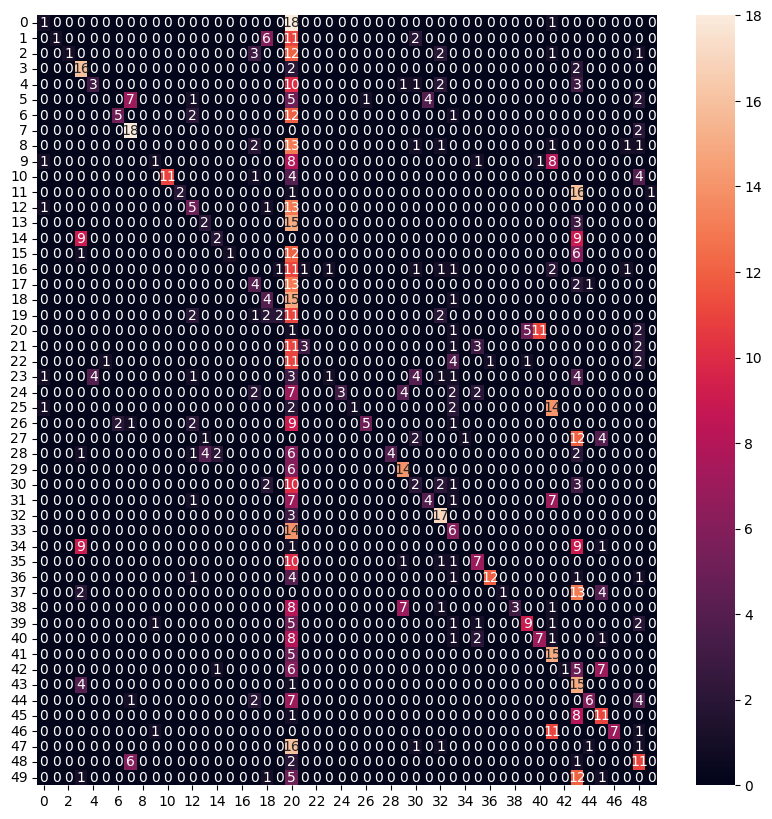

In [24]:
#LSTM
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))


output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'lstm'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model.load_state_dict(torch.load("./data/baseline.pt"))
model = model.to(device)
# print(len(word_embeddings), len(TEXT.vocab.itos))
# print(len(word_embeddings[0]))
# print(len(TEXT.vocab))
# vocab_dict = TEXT.vocab.stoi
# vocab_list = TEXT.vocab.itos
# print(vocab_dict["thursday"])


loss_function = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# log_dir = 'runs/lstm1'
# final_acc_train_lstm  = []
# final_loss_train_lstm = []
# final_loss_test_lstm = []
# final_acc_test_lstm = []
# final_f1score_train_lstm = []
# final_f1score_test_lstm = []


# for multi in range(20):
#   loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
#   overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
#   final_acc_train_lstm.append(accs[0])
#   final_acc_test_lstm.append(accs_test[0])
#   final_f1score_train_lstm.append(f1score[0])
#   final_f1score_test_lstm.append(f1ss)
#   final_loss_train_lstm.append(loss_train[0])
#   final_loss_test_lstm.append(loss_test[0])

overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, attack_iterator, loss_function)
# torch.save(model.state_dict(), "/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/baseline.pt")

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

In [ ]:
print(auth_sort[6])

DarrenSchuettler


In [13]:
n = len(attack_iterator)
avg_sim = 0

for i in range(n):
    avg_sim += similarity_cal(" ".join(val_iterator.data()[i].text), " ".join(attack_iterator.data()[i].text))
    
avg_sim /= n

print(avg_sim)

0.4237763471901417


In [ ]:
"""
This part is to find top 5 closest words of a certain word.
We use euclidean distance in word embedding to calculate.
"""
words_in_article = []
for info in train.examples[0].text:   # train.examples[0].text is the input article
  words_in_article.append(vocab_dict[info])

words_in_article = torch.tensor(words_in_article, dtype=torch.int64)
output = model.embedding(words_in_article)
np_word_dict = {}

# create dictionary of word-embedding pair of np.array of embeddings
for i in range(len(output)):
  # print(tmp[i])
  # print(vocab_list[tmp[i]])
  # print(output[i])
  li = [float(num) for num in output[i]]
  # print(li, len(li))
  np_word_dict[vocab_list[words_in_article[i]]] = np.array(li)

# print(np_word_dict)

In [ ]:
# calculate closest word by euclidean distance in word embedding
def find_closest_embeddings(embedding):
    return sorted(np_word_dict.keys(), key=lambda word: spatial.distance.euclidean(np_word_dict[word], embedding))

alternatives = []

for retired in to_replace:
  alternatives.append(find_closest_embeddings(np_word_dict[retired])[1:6])  # [1:6] is because [0] will always be itself

print(alternatives)

[['(', '.', ',', 'is', 'also'], ['last', 'one', 'over', ',', 'with'], ['<unk>', '\n', ' \n', 'exception', '898'], [')', ',', '.', 'or', 'from'], ['\n', '8312', '<unk>', ' \n', 'respectively']]


GRU

In [ ]:
#GRU
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))



output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'gru'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/gru'
final_acc_train_gru  = []
final_acc_test_gru = []
final_f1score_train_gru = []
final_f1score_test_gru = []
final_loss_train_gru = []
final_loss_test_gru = []

for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_gru.append(accs[0])
  final_loss_train_gru.append(loss_train[0])
  final_acc_test_gru.append(accs_test[0])
  final_f1score_train_gru.append(f1score[0])
  final_f1score_test_gru.append(f1ss)
  final_loss_test_gru.append(loss_test[0])


cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

BiLSTM

In [ ]:
#bilstm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))



output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'bilstm'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/bilstm'
final_acc_train_bilstm  = []
final_acc_test_bilstm = []
final_f1score_train_bilstm = []
final_f1score_test_bilstm = []
final_loss_train_bilstm = []
final_loss_test_bilstm = []

for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_bilstm.append(accs[0])
  final_loss_train_bilstm.append(loss_train[0])
  final_acc_test_bilstm.append(accs_test[0])
  final_f1score_train_bilstm.append(f1score[0])
  final_f1score_test_bilstm.append(f1ss)
  final_loss_test_bilstm.append(loss_test[0])


cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

Plot - Accuracy

In [ ]:
#Plot - accuracy
import plotly.graph_objects as go
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training accuracy lstm'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing accuracy lstm'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training accuracy gru'))
fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_gru,
    connectgaps=True, marker_color = 'rgba(0, 255, 0, 0.9)', name = 'Testing accuracy gru'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training accuracy bilstm'))
fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_bilstm, connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)',
    name='Test accuracy bilstm'))

fig_accuracy.show()

Loss Plots

In [ ]:
#Loss Plots
import plotly.graph_objects as go
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training Loss lstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing Loss lstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training Loss gru'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_gru,
    connectgaps=True, marker_color='rgba(0, 255, 0, 0.9)', name = 'Testing Loss gru'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training Loss bilstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)', name = 'Testing Loss bilstm'))

fig_loss.show()

F1 Score plots

In [ ]:
#Plot - f1score
import plotly.graph_objects as go
fig_f1score = go.Figure()

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training f1score lstm'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing f1score lstm'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training f1score gru'))
fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_gru,
    connectgaps=True, marker_color = 'rgba(0, 255, 0, 0.9)', name = 'Testing f1score gru'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training f1score bilstm'))
fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_bilstm, connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)',
    name='Test f1score bilstm'))

fig_f1score.show()